# Assignment 2: Sensitivity Analysis with PRCCs via LHS
#### Moritz Kick, Rami El Immam, Maximilian Nowak

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

# Implement the SEIR-Model from Assignment 1

In [2]:
beta = 14/9  # infection rate
alpha = 7/3  # incubation rate
gamma = 7/9  # recovery rate
i0 = 1000  # initial number of infected individuals

# Define initial conditions
N = 80e6
S0 = N - i0
E0 = 0
I0 = i0
R0 = 0
C0 = I0
y0 = [S0, E0, I0, R0, C0]

# Define the system of differential equations
def seirc(y, t, beta, alpha, gamma, N):
    S, E, I, R, C = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    DCdt = alpha * E
    return [dSdt, dEdt, dIdt, dRdt, DCdt]

### 1. Implement the LHS method for $n$-dimensional uniformly distributed random vectors.

In [3]:
def latin_hypercube_uniform(dim, n_samples, low=0, high=1):
    rand_matrix = np.empty((n_samples, dim))
    subintervals, stepsize = np.linspace(0, 1, n_samples+1, retstep=True)
    
    # generate uniformely distributed samples
    for i in range(dim):
        for j, min in enumerate(subintervals[:-1]):
            rand_matrix[j, i] = np.random.uniform(min, min+stepsize)

    # permute the columns
    for i in range(dim):
        rand_matrix[:, i] = np.random.permutation(rand_matrix[:, i])
        
    return rand_matrix * (high - low) + low 

### 2. Verify your implementation.

(20, 2)


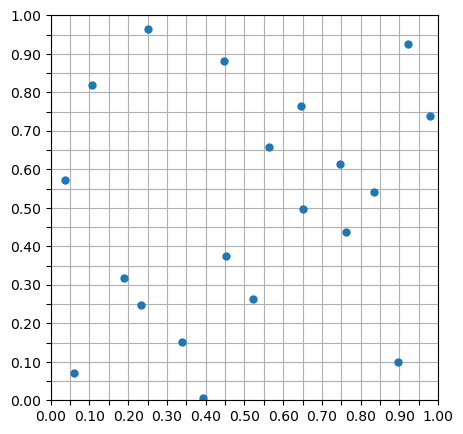

In [4]:
samples = latin_hypercube_uniform(2, 20)
print(samples.shape)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(0, 1.01, 0.05))
ax.set_yticks(np.arange(0, 1.01, 0.05))
ax.set_xticklabels([x if not i%2 else "" for i, x in enumerate(ax.get_xticklabels())])
ax.set_yticklabels([y if not i%2 else "" for i, y in enumerate(ax.get_yticklabels())])
plt.rc('grid', linestyle="--", color='lightgrey')
plt.grid()

plt.plot(samples[:, 0], samples[:, 1], ".", markersize="10")
plt.show()

In [5]:
# as proof check for duplicate values

u_col, c_col = np.unique(samples[:, 0], return_counts=True)
print(u_col[c_col > 1])

u_row, c_row = np.unique(samples[:, 1], return_counts=True)
print(u_row[c_row > 1])

[]
[]


### 3. Implement the computation of PCCs (not $\mathrm{P} R \mathrm{CCs}$ )

In [19]:

def partial_corrcoef(X, y):
    X = X.astype(np.float128)
    
    dim, N = X.shape
    pcc = []
    X = np.c_[X, np.ones(dim)]
    
    for i in range(N):
        X_partial = np.delete(X, i, 1)
        x_i = X[:, i]
        
        wx_i = lstsq(X_partial, x_i)[0]
        x_res = x_i -  X_partial @ wx_i

        wy_i = lstsq(X_partial, y)[0]
        y_res = y - X_partial @ wy_i

        pcc.append(np.dot(x_res, y_res) / (np.sqrt(np.sum(x_res**2)) * np.sqrt(np.sum(y_res**2))) )
        # print(np.corrcoef(x_res.T, y_res.T, dtype = np.float128))
        # pcc.append(np.corrcoef(x_res.T, y_res.T, dtype = np.float128)[0, 1])

    return pcc

X = np.array([[0.60764046, 1.58738051, 1.13891271, 8.96894346], \
 [5.90198269, 9.81622908, 5.34844086, 1.97889509],\
 [7.77495547, 3.5850063,  3.46742104, 7.00439459],\
 [4.73871726, 6.76844208, 8.17972315, 4.73370597]])

y = X[:, 0]
print(X)
pccs = partial_corrcoef(X, y)
print(pccs)


[[0.60764046 1.58738051 1.13891271 8.96894346]
 [5.90198269 9.81622908 5.34844086 1.97889509]
 [7.77495547 3.5850063  3.46742104 7.00439459]
 [4.73871726 6.76844208 8.17972315 4.73370597]]
[0.99999999999999999995, 0.8580693530361787362, 0.8236368811940932896, -0.8504421891110768344]


In [17]:
import numpy as np
import numpy.linalg as lin

def partial_corrcoef(X, y):
    dim, N = X.shape
    pcc = []

    for i in range(N):
        X_filtered = np.delete(X, i, 1)
        X_part = np.column_stack((X_filtered, np.ones(dim)))
        x_i = X[:, i]

        wx_i = lin.lstsq(X_part, x_i, rcond=None)[0]
        x_res = x_i - np.dot(X_part, wx_i)

        wy_i = lin.lstsq(X_part, y, rcond=None)[0]
        y_res = y - np.dot(X_part, wy_i)

        #pcc.append(np.corrcoef(x_res, y_res)[0, 1])
        pcc.append(np.dot(x_res, y_res)/(np.sqrt(np.sum(x_res**2)) * np.sqrt(np.sum(y_res**2))))

    return pcc

X = np.array([[0.60764046, 1.58738051, 1.13891271, 8.96894346], \
 [5.90198269, 9.81622908, 5.34844086, 1.97889509],\
 [7.77495547, 3.5850063,  3.46742104, 7.00439459],\
 [4.73871726, 6.76844208, 8.17972315, 4.73370597]])

y = X[:, 0]

pccs = partial_corrcoef(X, y)
print(pccs)

[0.9999999999999998, 0.8495980067837471, 0.8419649816899835, -0.8079576198680359]


### 4. Verify the PCC computation

In [7]:
X = latin_hypercube_uniform(4, 4, 0, 10)

y = X[:, 0]

pccs = partial_corrcoef(X, y)
print(pccs)

[1.0, 1.0, -0.26918192632737271522, -0.35806121458415450515, 0.061185718314683256634, -0.03246732075284891803, 0.6511651582081244034, -0.026284356626295812197]


### 5. Find out how to easily compute PRCCs with the above function for PCCs.

In [26]:
def prcc(X, y):
    X = X.argsort(axis=0).argsort(axis=0)
    y = y.argsort().argsort()
    return partial_corrcoef(X, y)

X = latin_hypercube_uniform(2, 4, 0, 10)
y = X[:, 0] + X[:, 1]

print(prcc(X, y))

y = X[:, 0] + X[:, 1]**4

print(prcc(X, y))

y = X[:, 0] + np.tan(X[:, 1]**(4))**(-1)

print(prcc(X, y))

[-2.9159993031161302442e-06, 0.99999999999999999995]
[-2.9159993031161302442e-06, 0.99999999999999999995]
[0.9525793444156803716, -0.9456108576893003189]


### 6. Construct the parameter domain $\mathcal{X}$.

In [ ]:
beta_range = [1, 3]  # average number of contacts per week
alpha_range = [2, 14]  # mean latency period in days
gamma_range = [7, 14]  # mean recovery period in days
i0_range = [500, 2500]  # initial number of infected individuals

param_domain = np.array([beta_range, alpha_range, gamma_range, i0_range])
print(param_domain)

[[   1    3]
 [   2   14]
 [   7   14]
 [ 500 2500]]


### 7. Estimate the PRCCs between $Y_{\ell}=\mathcal{G}_{\ell}(\boldsymbol{X}), \ell=1,2$, and the input parameters $\boldsymbol{X} \sim \mathcal{U}(\mathcal{X})$ using $N=1,000$ LHS samples.

In [ ]:
N_samples = 1000  # Number of LHS samples

# simulation time
T = 60
t = np.linspace(0, T, T+1)

x0 = (beta, alpha, gamma, N)
y0 = S0, E0, I0, R0, C0

lhs_samples = latin_hypercube_uniform(4, N_samples, low=param_domain[:, 0], high=param_domain[:, 1])
print(lhs_samples.shape)

# Run the SEIRC model for each set of LHS samples
results_g1 = []
results_g2 = []
for i in range(N_samples):
    beta, alpha, gamma, i0 = lhs_samples[i]
    sol = odeint(seirc, y0, t, args=(beta, alpha, gamma, N))
    
    results_g1.append(sol[-1, 4])  # Store the cumulative number of cases at the end of the simulation
    results_g2.append(sol[:, 2].max())  # Store the maximum value of I
    

results_g1 = np.array(results_g1)
results_g2 = np.array(results_g2)

# Compute PRCCs
prcc_g1 = prcc(lhs_samples, results_g1)
prcc_g2 = prcc(lhs_samples, results_g2)


(1000, 4)


/home/mnowak/miniconda3/envs/uq/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


### Display the PRCCs with a bar plot.

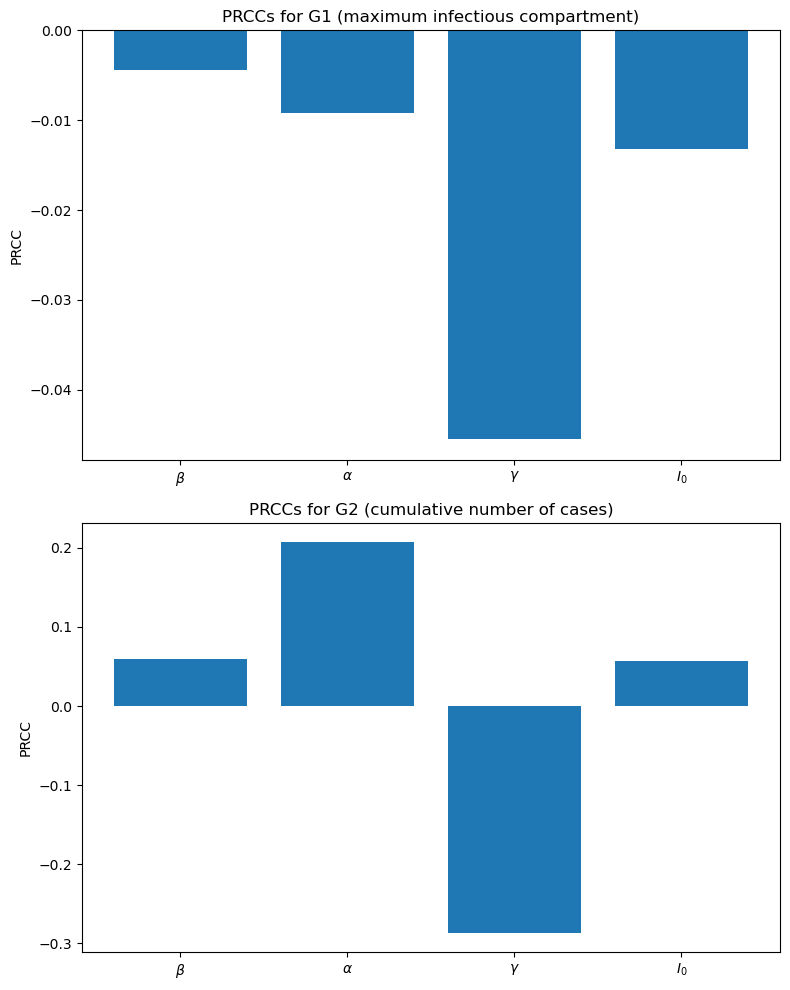

In [ ]:
labels = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$I_0$']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.bar(labels, prcc_g1)
ax1.set_ylabel('PRCC')
ax1.set_title('PRCCs for G1 (maximum infectious compartment)')

ax2.bar(labels, prcc_g2)
ax2.set_ylabel('PRCC')
ax2.set_title('PRCCs for G2 (cumulative number of cases)')

plt.tight_layout()
plt.show()
